In [1]:
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random


def mock(num=10, size=10, seed=None):
    "return dataframe of simulated objects"
    if seed is not None:
        np.random.seed(seed)
    obj = np.random.random(size=(num, 3))
    obj[:, 0:2] *= size
    obj[:, 1] -= size / 2  # The location is scaled to simulate objects on a 10x10 grid.
    # objid = np.arange(obj.shape[0]) # object id
    df = pd.DataFrame(obj, columns=["x", "y", "u"])
    return df


def cat(mdf):
    "return simulated catalog and selection"
    sigma = 1 / 100 * np.random.randint(4, 10, (mdf.shape[0], 1))
    det = mdf.values[:, :2] + sigma * np.random.randn(mdf.shape[0], 2)
    df = pd.DataFrame(det, columns=["x", "y"])
    df["Sigma"] = sigma
    a, b = (0, 1)
    sel = np.logical_and(mdf.u >= a, mdf.u < b)
    # df['selected'] = np.array(sel, dtype=np.bool)
    return df.values, sel


def random_cat(mdf):
    "return simulated catalog with random selection intervals"
    sigma = 1 / 100 * np.random.randint(4, 10, (mdf.shape[0], 1))
    det = mdf.values[:, :2] + sigma * np.random.randn(mdf.shape[0], 2)
    df = pd.DataFrame(det, columns=["x", "y"])
    df["Sigma"] = sigma
    num_endpoints = random.randrange(
        6, 10, 2
    )  # Random multiple of 2 from 6 to 16 #So the number of intervals = num_endpoints / 2
    endpoints_list = sorted([random.random() for x in range(num_endpoints)])
    selection_boolean_list = []
    for index in range(int(num_endpoints / 2)):
        a = endpoints_list[2 * index]
        b = endpoints_list[2 * index + 1]
        sel = np.logical_and(mdf.u >= a, mdf.u < b)
        selection_boolean_list.append(sel)
    final_sel = selection_boolean_list[0]
    for i in range(1, int(num_endpoints / 2)):
        final_sel = final_sel | selection_boolean_list[i]
    df = df[final_sel].values
    return df, final_sel

In [2]:
# Parameters
np.random.seed(42)
num = 100
size = 30
num_catalog = 5

Qmat = np.empty((1, 2))
m = mock(num=num, size=size, seed=20)

# generate catalogs with sigma=0.1" and different selection intevals
cmat = []
sel_list = []

for _ in range(num_catalog):  # List of catalogs with coordinates and conditions
    catalog_i, final_sel = cat(m)
    cmat.append(catalog_i)
    sel_list.append(final_sel)

true_matching_dict = {}
count_list = [0] * num
for source_index in range(num):
    index_list = []
    for catalog_index in range(num_catalog):
        if sel_list[catalog_index][source_index] == True:
            index_list.append((catalog_index, count_list[catalog_index]))
            count_list[catalog_index] += 1
    true_matching_dict[source_index] = index_list

# fig = plt.figure(figsize=(20, 20))
# for i in range(num_catalog):
#     x, y = cmat[i][:, :2].T
#     plt.scatter(x, y)
# plt.show()

m

,x,y,u
0,17.643924,11.931412,0.891531
1,24.475124,-13.923312,0.691758
2,11.360428,0.555328,0.657951
3,5.815507,-6.830508,0.718606
4,23.490108,10.509829,0.775245
...,...,...,...
95,17.765019,-0.116515,0.916652
96,19.405981,-11.086072,0.814694
97,6.384901,-13.748479,0.349609
98,20.920018,-7.102501,0.319837


In [5]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [4]:
def neg_log_bayes_factor(cluster: np.array):
    """
    Calculate the negative log Bayes Factor for a given clustering.
    
    cluster is an numpy array with shape (n, 3) where n is the number of
    sources in the cluster.
    
    The first column is the first coordinate, the second column is the second, and
    the third column is the uncertainty.
    
    See Nguyen et al. 2022 for details on the Bayes factor.
    """
    num_objects = cluster.shape[0]

    kappas = np.reciprocal(cluster.T[2] ** 2) # kappa = 1/sigma^2
    sum_kappas = np.sum(kappas) # sum of all kappas
    
    # First 3 terms in formula
    neg_bayes = (1 - num_objects) * np.log(2) - np.sum(np.log(kappas)) + np.log(sum_kappas)
    
    # Double sum in formula
    pairwise_dist = pdist(cluster[:,:2], metric="sqeuclidean") # get pairwise squared distances
    kappas_prod = kappas[:,None] * kappas # get pairwise products (vectorized)
    np.fill_diagonal(kappas_prod, 0) # fill the diagonal with 0's for the next line
    kappas_prod_square = squareform(kappas_prod) # convert to condensed distance vector
    
    # Add final term
    neg_bayes += np.sum(kappas_prod_square * pairwise_dist) / (4 * sum_kappas)
    
    return neg_bayes

In [15]:
def assign_cluster_neg_bayes(cluster_labels: np.array, data: np.array) -> float:
    """Calculate the total negative log bayes factor for a given clustering.

    Args:
        cluster_labels (np.array): n by 1 array of cluster labels.
        data (np.array): n by 3 array of data points.

    Returns:
        float: sum of negative log bayes factors for each cluster.
    """
    neg_bayes = 0
    for label in np.unique(cluster_labels):
        cluster = data[cluster_labels == label, :]
        neg_bayes += neg_log_bayes_factor(cluster)
    return neg_bayes

def find_clusters_single_linkage(
    cmat: np.array,
) -> tuple[np.array, int, float, list[float]]:
    """Find clusters using single linkage clustering."""

    data = np.concatenate(cmat, axis=0)
    linkage_arr = linkage(data[:, :2], method="single")

    bayes = []
    best_bayes = np.inf
    for n in range(75, data.shape[0]):
        cluster_labels = fcluster(linkage_arr, t=n, criterion="maxclust")
        bayes_factor = assign_cluster_neg_bayes(cluster_labels, data)
        bayes.append(bayes_factor)
        if bayes_factor < best_bayes:
            best_bayes = bayes_factor
            best_labels = cluster_labels
            best_n = n

    return best_labels, best_n, best_bayes, bayes

In [28]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score
ari = adjusted_rand_score

def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from scipy.optimize import linear_sum_assignment
    ind = np.asarray(linear_sum_assignment(w.max() - w)).T
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [16]:
best_labels, best_n, best_bayes, bayes = find_clusters_single_linkage(cmat)

In [23]:
ground_truth_labels = np.tile(np.array(range(100)), 5)

In [29]:
acc(ground_truth_labels, best_labels)

0.98

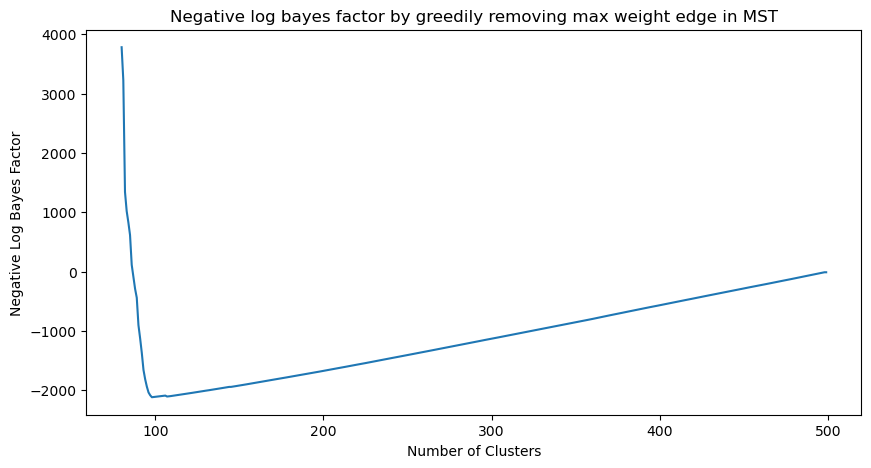

In [10]:
plt.figure(figsize=(10,5))
plt.plot(range(start_cluster,data.shape[0]), bayes)
plt.xlabel("Number of Clusters")
plt.ylabel("Negative Log Bayes Factor")
plt.title("Negative log bayes factor by greedily removing max weight edge in MST")
plt.show()

In [11]:
min(bayes)

-2120.4619475208788